Disentangled representations with $\beta$-VAE and forced learning of some traits for Radio Galaxies

In [12]:
%load_ext autoreload
%autoreload 2

import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm
import matplotlib.gridspec as gridspec


from skimage import exposure
from skimage import measure
from skimage.io import imsave
from skimage.filters import gaussian as gaussian_filter
from skimage.filters import threshold_otsu
from skimage import filters
from skimage.morphology import opening, closing, disk, binary_dilation, flood

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sys.path.append('../')
from VAE.rg_dataset import LRG, BasicDataset
from VAE.vae_models import VAE

In [3]:
%%time
data_path = '../data/'
aug=15
lrg_data_set   = LRG(use_kittler=True, n_aug=aug, blur=False, catalog_dir=data_path + 'catalog/mrt-table3.txt', 
                                                               file_dir=data_path + 'lrg')

unlrg_data_set = LRG(use_kittler=True, n_aug=aug, blur=False, catalog_dir=data_path + 'catalog/mrt-table4.txt',
                                                               file_dir=data_path + 'unlrg')

../data/lrg:	1442/1442
../data/unlrg:	14245/14245
CPU times: user 6min 20s, sys: 6min 50s, total: 13min 11s
Wall time: 4min 25s


In [4]:
# batch_size = 128
# data_loader_lrg   = data.DataLoader(lrg_data_set,   batch_size=batch_size, shuffle=False)
# data_loader_unlrg = data.DataLoader(unlrg_data_set, batch_size=batch_size, shuffle=True)

# sample = iter(data_loader_lrg).next()

In [5]:
data_path = '../data/'

lrg_images   = np.load(data_path+'proc_aligned2/lrg_norm_proc.npy', allow_pickle=True)
unlrg_images = np.load(data_path+'proc_aligned2/unlrg_norm_proc.npy', allow_pickle=True)

aug=15

my_lrg_dataset  = BasicDataset(lrg_images, lrg_data_set.labels, n_aug=10) #
my_unlrg_dataset  = BasicDataset(unlrg_images, unlrg_data_set.labels, n_aug=aug)

batch_size = 128
data_loader_lrg   = data.DataLoader(my_lrg_dataset,   batch_size=batch_size, shuffle=False)
data_loader_unlrg = data.DataLoader(my_unlrg_dataset, batch_size=batch_size, shuffle=True)

sample = iter(data_loader_lrg).next()

In [24]:
#Simple Variational Auto Encoder
class VAE(nn.Module):
    def __init__(self, lt_dim=4):
        super(VAE, self).__init__()
        self.k = [1, 16, 32, 64, 128, 256]
#         self.k = [1, 64, 128, 256, 512, 512]
        encoder_layers = []
        decoder_layers = []
        
        for i in range(len(self.k) - 1):
            layer = nn.Conv2d(self.k[i], self.k[i+1], 3, 2, 1, 1)
            encoder_layers.append(layer)
            encoder_layers.append(nn.ReLU())
        
        for i in range(len(self.k) - 1, 0, -1):
            layer = nn.ConvTranspose2d(self.k[i], self.k[i-1], 3, 2, 1, 1)
            decoder_layers.append(layer)
            decoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers[:-1])
        
        self.fc_mu = nn.Linear(self.k[-1]*2*2, lt_dim)
        self.fc_ep = nn.Linear(self.k[-1]*2*2, lt_dim)
        
        self.fc_dc = nn.Linear(lt_dim, self.k[-1]*2*2)
    def encode(self, x):
        encoded = self.encoder(x).view(-1, self.k[-1]*2*2)
        return self.fc_mu(encoded), self.fc_ep(encoded)
    
    def reparameterize(self, mu, logvar):
        if self.training :
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return mu + eps*std
        else :
            return mu

    def decode(self, x):
        x = F.relu(self.fc_dc(x)).view(-1, self.k[-1], 2, 2)
        return torch.sigmoid(self.decoder(x))
    
    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        d = self.decode(z)
        return d, mu, var

In [25]:
class B_VAE_Loss:
    def __init__(self, gamma, max_capacity, epochs):
        self.gamma = gamma
#         self.recon_ls = nn.MSELoss(reduction='sum')
        self.recon_ls = nn.BCELoss(reduction='sum')
        #self.recon_ls = nn.BCEWithLogitsLoss(reduction='sum')
        self.capacity = 0
        self.delta = max_capacity / float(epochs)
        self.max_capacity = max_capacity
    def update(self):
        self.capacity = min(self.max_capacity, self.capacity + self.delta)
        return self.capacity
    def __call__(self, res, img):
        batch_sz = len(img)
        x, mu, logvar = res
        recon = self.recon_ls(x, img).div(batch_sz) #res -> x, mu, var
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()).div(batch_sz)
        return self.capacity, recon, self.gamma * (kld - self.capacity).abs()

In [30]:
def train_step(model, device, data_loader, optim, epoch, log_interval=5):
    model.train()
    s = ''
#     s = 'Train Epoch: {:3d} [{:5d}/{:5d} ({:3.0f}%)]   Loss: {:4.4f}   R_Loss: {:4.4f}   Capacity: {:4.2f}'
    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.to(device)
        target = Variable(target, requires_grad=False).to(device)
        #Forward Pass
        optimizer.zero_grad()
        output = model(data)
        
        #############################################
        ######### check against known class #########
        #############################################
        #########    Compact vs Extended    #########
        extended = target > 1
        extended = Variable(extended.float().to(device), requires_grad=False)
        pred_ext = torch.sigmoid(output[1][:,0])
        ext_loss = F.binary_cross_entropy(pred_ext, extended, reduction='sum').div(len(pred_ext))
        #########       FRI vs FRII         #########
#         o = torch.sigmoid(output[1][:, 1])[target > 1]
#         c = target[target > 1]
#         o = o[c < 4]
#         c = c[c < 4]
#         c = Variable( (c == 3).float().to(device), requires_grad=False)
#         fr_loss = F.binary_cross_entropy(o, c, reduction='sum').div(len(c))
        #########   Regular vs Irregular   #########
#         o = torch.sigmoid(output[1][:, 2])[target > 1]
#         c = target[target > 1]
# #         o = o[c < 4]
#         c = c < 4
#         c = Variable( c.float().to(device), requires_grad=False)
#         reg_loss = F.binary_cross_entropy(o, c, reduction='sum').div(len(c))
        # BCE Loss
        c, r_loss , g_loss = beta_vae_loss(output, data)
        loss = r_loss + g_loss + 10 * (ext_loss)#+ fr_loss)# + reg_loss)
        #Backpropagation
        loss.backward()
        optimizer.step()
        s = 'Train Epoch: {:3d} ({:3.0f}%)  Loss: {:4.4f}  R_Loss: {:4.4f}  Capacity: {:4.2f}'
        s = s.format(epoch,
                100. * batch_idx / len(data_loader), loss.item(), r_loss.item(), c)
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    return s

In [31]:
def test_step(model, device, data_loader, optim, epoch, log_interval=5):
    model.train()
    loss = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        with torch.no_grad():
            data = data.to(device)
            #Forward Pass
            output = model(data)

            # BCE Loss
            c, r_loss , g_loss = beta_vae_loss(output, data)
            loss = r_loss #+ g_loss
    return loss

In [46]:
device = 'cuda'
lt_dim = 6
vae = VAE(lt_dim=lt_dim).to(device)
optimizer = Adam(vae.parameters(), lr=0.0005, weight_decay=1E-5)

lambda_lr = lambda epoch : np.power(0.75, epoch / 5)
scheduler = LambdaLR(optimizer, lr_lambda= lambda_lr)
# sys.stdout.write('{}   Test Loss : {:4.4f}   Time : {:.2f}   LR: {:.2f} s\n'.format(s, loss, t, scheduler.get_lr()[0]))

In [47]:
# for i in range(40):
#     m = np.power(0.75, i / 5)
#     print(i, 0.0005*m)

In [48]:
epochs = 40
gam = 10
cap = 5
beta_vae_loss = B_VAE_Loss(gamma=gam, max_capacity=cap, epochs=epochs)
for epoch in range(1, epochs+1):
    #LRG, forced params
    start = time.time()
    s = train_step(vae, 'cuda', data_loader_unlrg, optimizer, epoch)
    loss = test_step(vae, 'cuda', data_loader_lrg, optimizer, epoch)
    t = time.time() - start
    sys.stdout.write('{}   Test Loss : {:4.4f}   Time : {:.2f}s   LR: {}\n'.format(s, loss, t, scheduler.get_lr()[0]))
    beta_vae_loss.update()
    
    scheduler.step()

Train Epoch:   1 (100%)  Loss: 87.4811  R_Loss: 77.6820  Capacity: 0.00   Test Loss : 227.9347   Time : 88.81s   LR: 0.0005
Train Epoch:   2 (100%)  Loss: 87.9414  R_Loss: 78.3874  Capacity: 0.12   Test Loss : 219.4460   Time : 88.22s   LR: 0.000472043755647451
Train Epoch:   3 (100%)  Loss: 100.6186  R_Loss: 89.6048  Capacity: 0.25   Test Loss : 210.9360   Time : 88.49s   LR: 0.00044565061449150083
Train Epoch:   4 (100%)  Loss: 81.6273  R_Loss: 73.8382  Capacity: 0.38   Test Loss : 204.7045   Time : 87.68s   LR: 0.0004207331795423248
Train Epoch:   5 (100%)  Loss: 127.8560  R_Loss: 113.8435  Capacity: 0.50   Test Loss : 203.7006   Time : 91.65s   LR: 0.0003972089403933046
Train Epoch:   6 (100%)  Loss: 96.8705  R_Loss: 89.7671  Capacity: 0.62   Test Loss : 205.9713   Time : 87.37s   LR: 0.000375
Train Epoch:   7 (100%)  Loss: 90.5738  R_Loss: 84.0461  Capacity: 0.75   Test Loss : 202.7419   Time : 87.92s   LR: 0.00035403281673558823
Train Epoch:   8 (100%)  Loss: 84.2718  R_Loss: 77.

In [ ]:
# scheduler.get_lr()

In [49]:
torch.save(vae, 'b_vae_soft2')

(-0.5, 63.5, 63.5, -0.5)

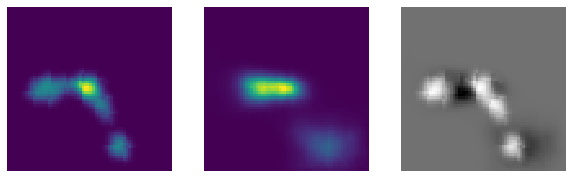

In [50]:
a = 1#6
s, l = sample[0][a:a+1], sample[1][a:a+1]
with torch.no_grad():
    e = vae.encode(s.to(device))[0]
    d = vae.decode(e)
f, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(s[0][0])
ax[1].imshow(d.cpu()[0][0])
ax[2].imshow(s[0][0] - d.cpu()[0][0], cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')


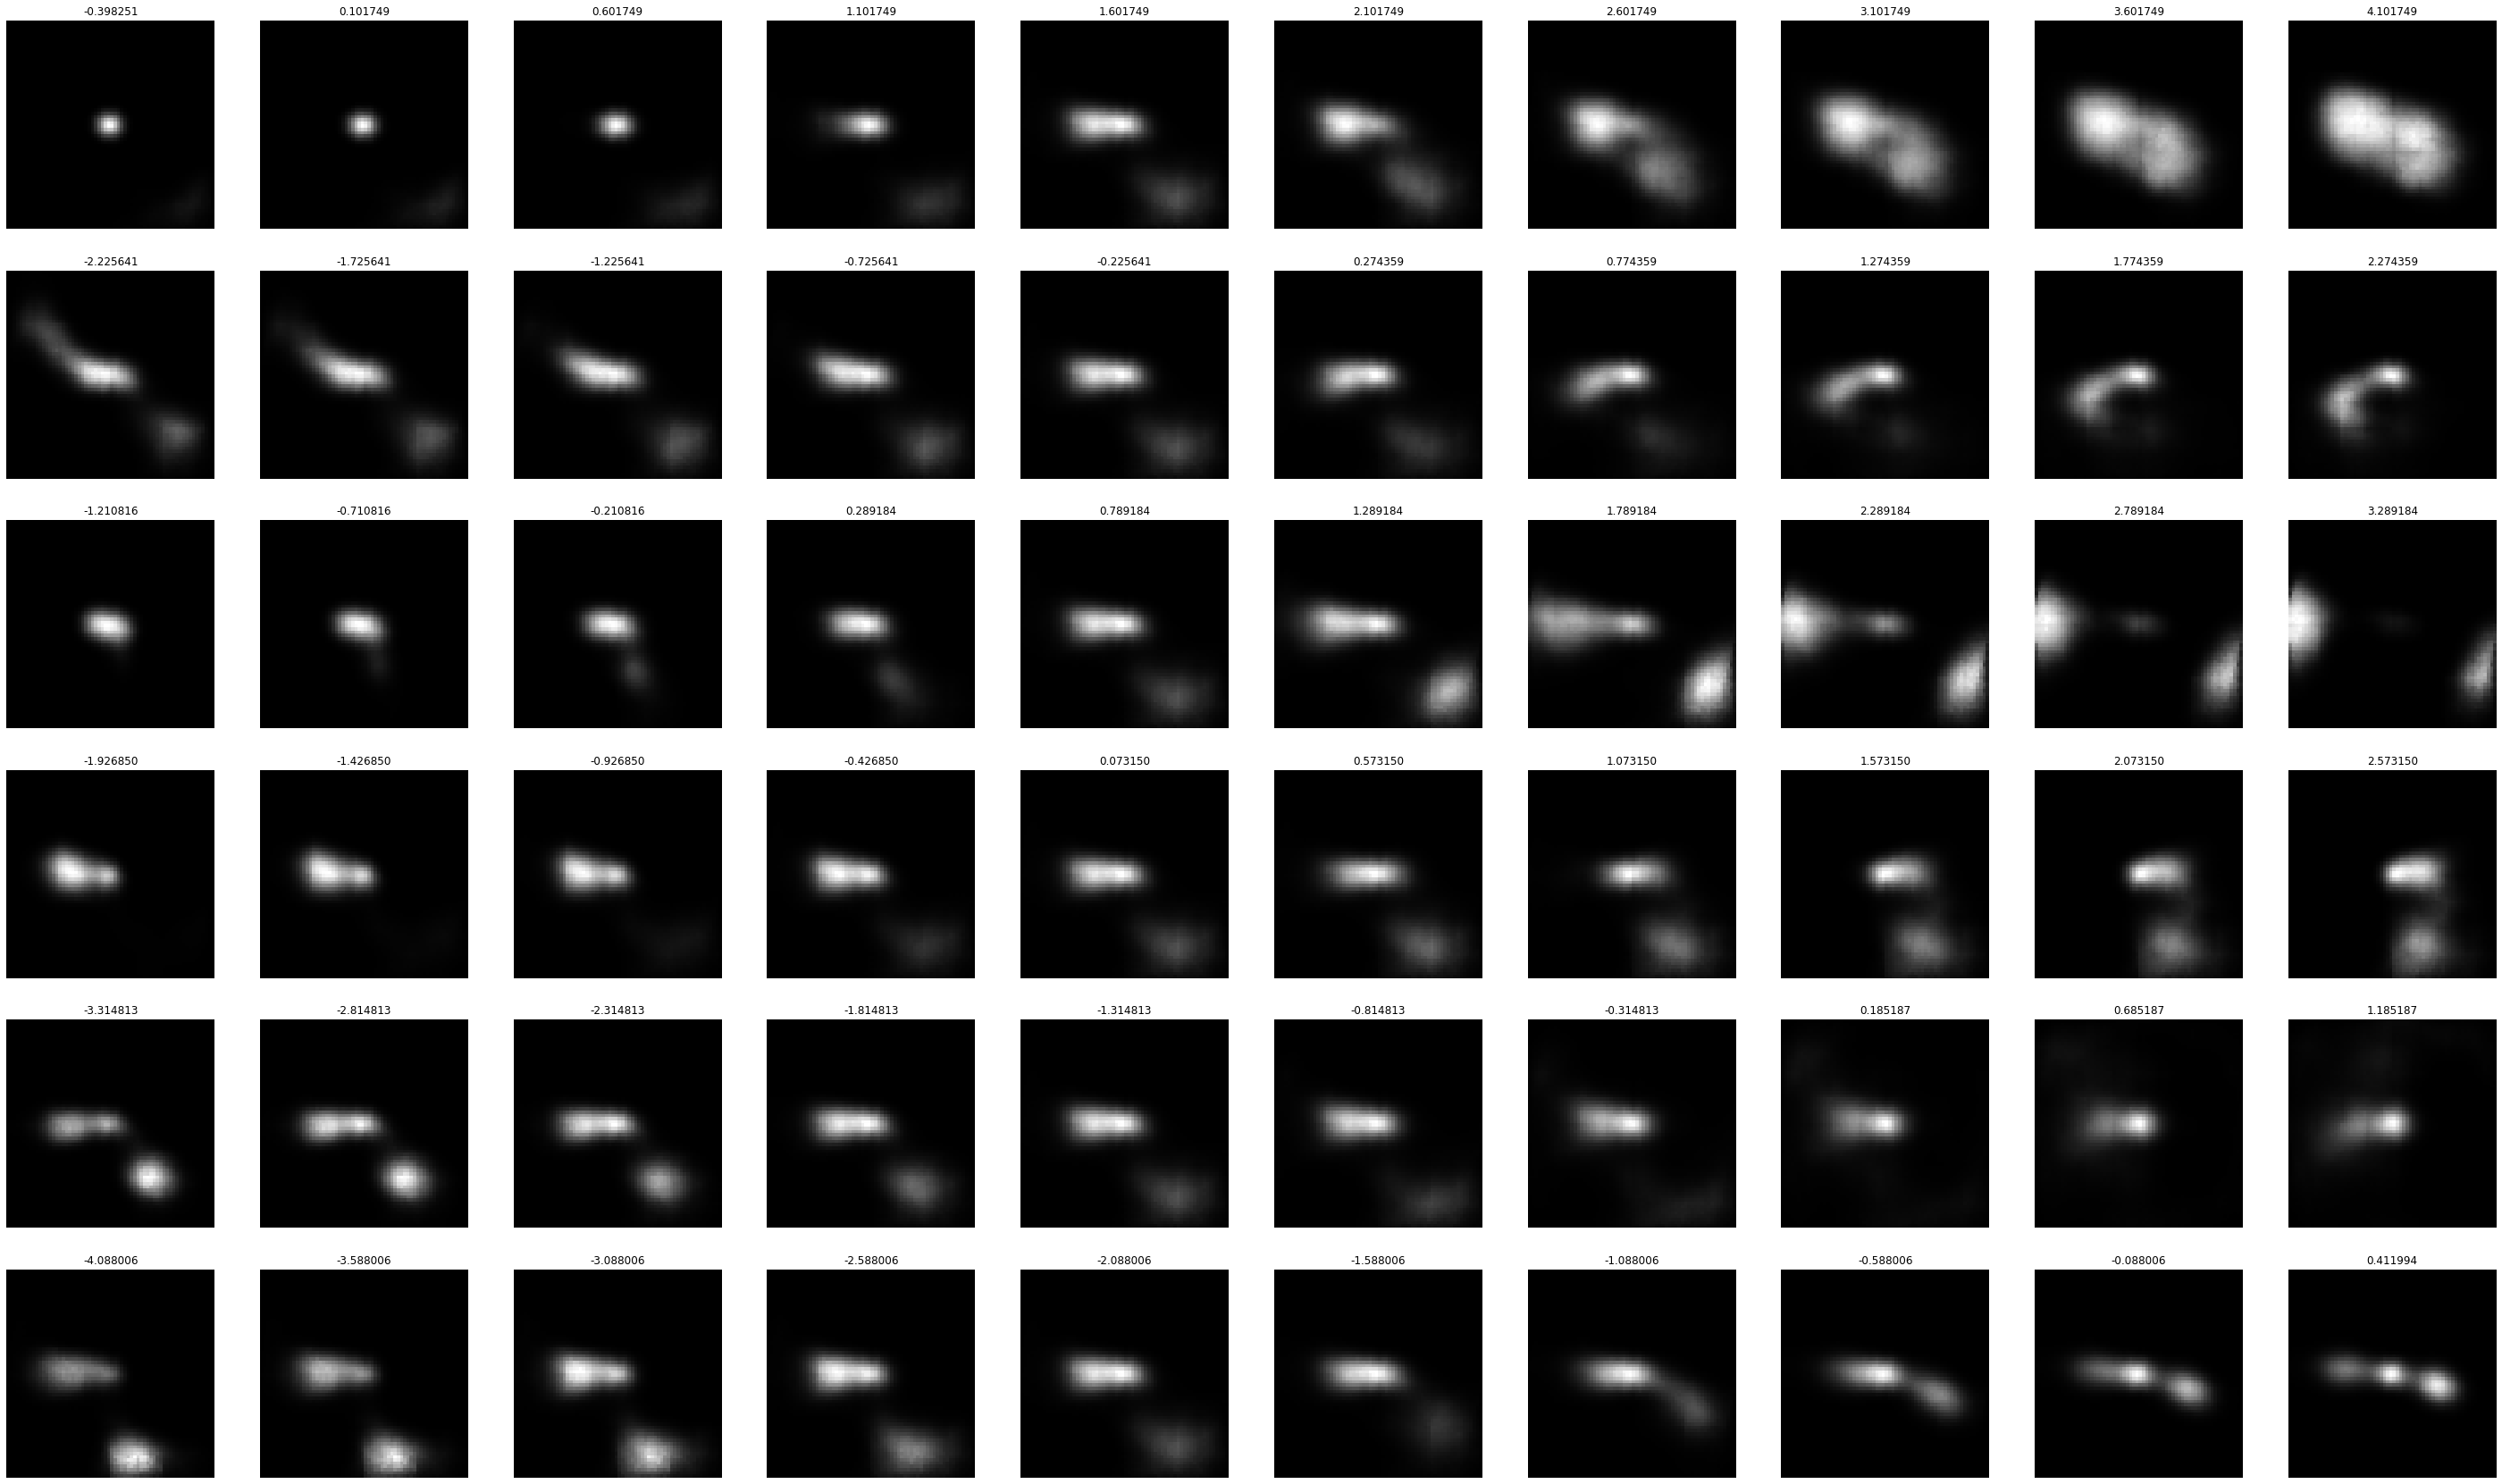

In [51]:
r = 10
nimg = r * lt_dim
k = .5
m = 1
f, ax = plt.subplots(int(nimg/r), r, figsize=(r * 5, nimg * 5 / r))
for i in range(int(nimg/r)):
    for j in range(r):
        with torch.no_grad():
            e = vae.encode(s.to(device))[0]
            v = e[0][i]
            nv = -4*k + v + k*j
            e[0][i] = nv
            d = vae.decode(e).cpu()[0][0]
        ax[i][j].imshow(d, cmap='gray')
        ax[i][j].axis('off')
        ax[i][j].set_title('{:2f}'.format(nv))

In [52]:
# r = 15
# nimg = r * 15

# plt.figure(figsize=(101.3, 104))
# gs1 = gridspec.GridSpec(15, r)
# gs1.update(wspace=0.01, hspace=0.01)

# k = 0.5

# for i in range(15):
#     for j in range(r):
#         ax1 = plt.subplot(gs1[i*r+j])
#         plt.axis('off')
#         with torch.no_grad():
#             e = torch.Tensor([2, k*(-j/2 + j), k*(-i/2  + i), 1, 1, 1]).cuda()
#             d = vae.decode(e).cpu()[0][0]
#         ax1.imshow(d, cmap='gray')
#         ax1.set_aspect('equal')